<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset
!wget works only in IBM Watson Studio. As far as I am working through Anaconda JupyterLab. therefore I use direct link on the file


In [2]:
#!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

### Load Data From CSV File


In [3]:
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: ...working... done

# All requested packages already installed.



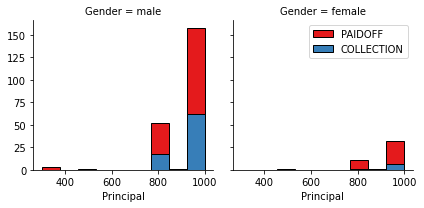

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

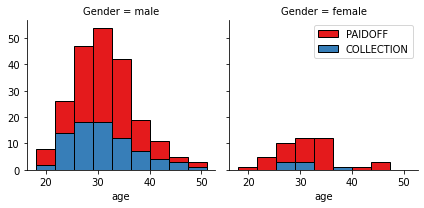

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


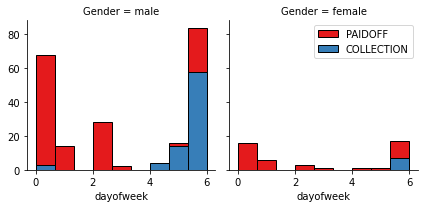

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
X1 = preprocessing.StandardScaler().fit(X).transform(X)
print(X1[0:5])
print (X1.shape) # shape of our dataset

[[ 0.51578458  0.92071769  2.33152555 -0.42056004 -1.20577805 -0.38170062
   1.13639374 -0.86968108]
 [ 0.51578458  0.92071769  0.34170148  2.37778177 -1.20577805  2.61985426
  -0.87997669 -0.86968108]
 [ 0.51578458 -0.95911111 -0.65321055 -0.42056004 -1.20577805 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769 -0.48739188  2.37778177  0.82934003 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769 -0.3215732  -0.42056004  0.82934003 -0.38170062
  -0.87997669  1.14984679]]
(346, 8)


In [21]:
#
from sklearn.model_selection import train_test_split
X1_train, X1_test, y_train, y_test = train_test_split( X1, y, test_size=0.2, random_state=4)
print ('Train set:', X1_train.shape,  y_train.shape)
print ('Test set:', X1_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [23]:
# Train a KNN model and choose the best fitting K in the rangr from 1 to 10
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X1_train,y_train)
    yhat=neigh.predict(X1_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.67142857, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.77142857])

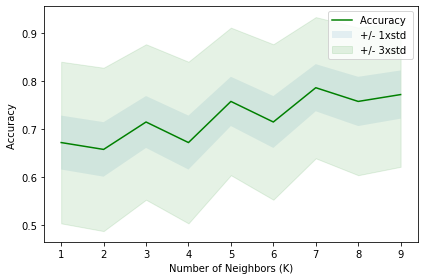

In [24]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [25]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


# Decision Tree


In [26]:
#Decision Tree Modelling for Loan Status
from sklearn.tree import DecisionTreeClassifier

In [27]:
X2 = Feature
y2 = df['loan_status'].values

In [28]:
X2_trainset, X2_testset, y2_trainset, y2_testset = train_test_split(X2, y2, test_size=0.3, random_state=3)
print(X2_trainset.shape, X2_testset.shape, y2_trainset.shape, y2_testset.shape)

(242, 8) (104, 8) (242,) (104,)


In [29]:
#Training th Model
LoanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
LoanTree # it shows the default parameters

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [30]:
LoanTree.fit(X2_trainset,y2_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [31]:
#Prediction
LoanpredTree = LoanTree.predict(X2_testset)
print (LoanpredTree [0:5])
print (y2_testset [0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF']


In [32]:
#Evaluation
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y2_testset, LoanpredTree))

DecisionTrees's Accuracy:  0.6538461538461539


In [33]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: ...working... 
  - anaconda/win-64::ca-certificates-2020.10.14-0, anaconda/win-64::openssl-1.1.1h-he774522_0
  - anaconda/win-64::ca-certificates-2020.10.14-0, defaults/win-64::openssl-1.1.1h-he774522_0
  - anaconda/win-64::openssl-1.1.1h-he774522_0, defaults/win-64::ca-certificates-2020.10.14-0
  - defaults/win-64::ca-certificates-2020.10.14-0, defaults/win-64::openssl-1.1.1h-he774522_0done

# All requested packages already installed.

Solving environment: ...working... 
  - anaconda/win-64::ca-certificates-2020.10.14-0, anaconda/win-64::openssl-1.1.1h-he774522_0
  - anaconda/win-64::ca-certificates-2020.10.14-0, defaults/win-64::openssl-1.1.1h-he774522_0
  - anaconda/win-64::openssl-1.1.1h-he774522_0, defaults/win-64::ca-certificates-2020.10.14-0
  - defaults/win-64::ca-certificates-2020.10.14-0, defaults/win-64::openssl-1.1.1h-he774522_0done

# All requested packages already installed.



In [34]:
#Visualisation
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

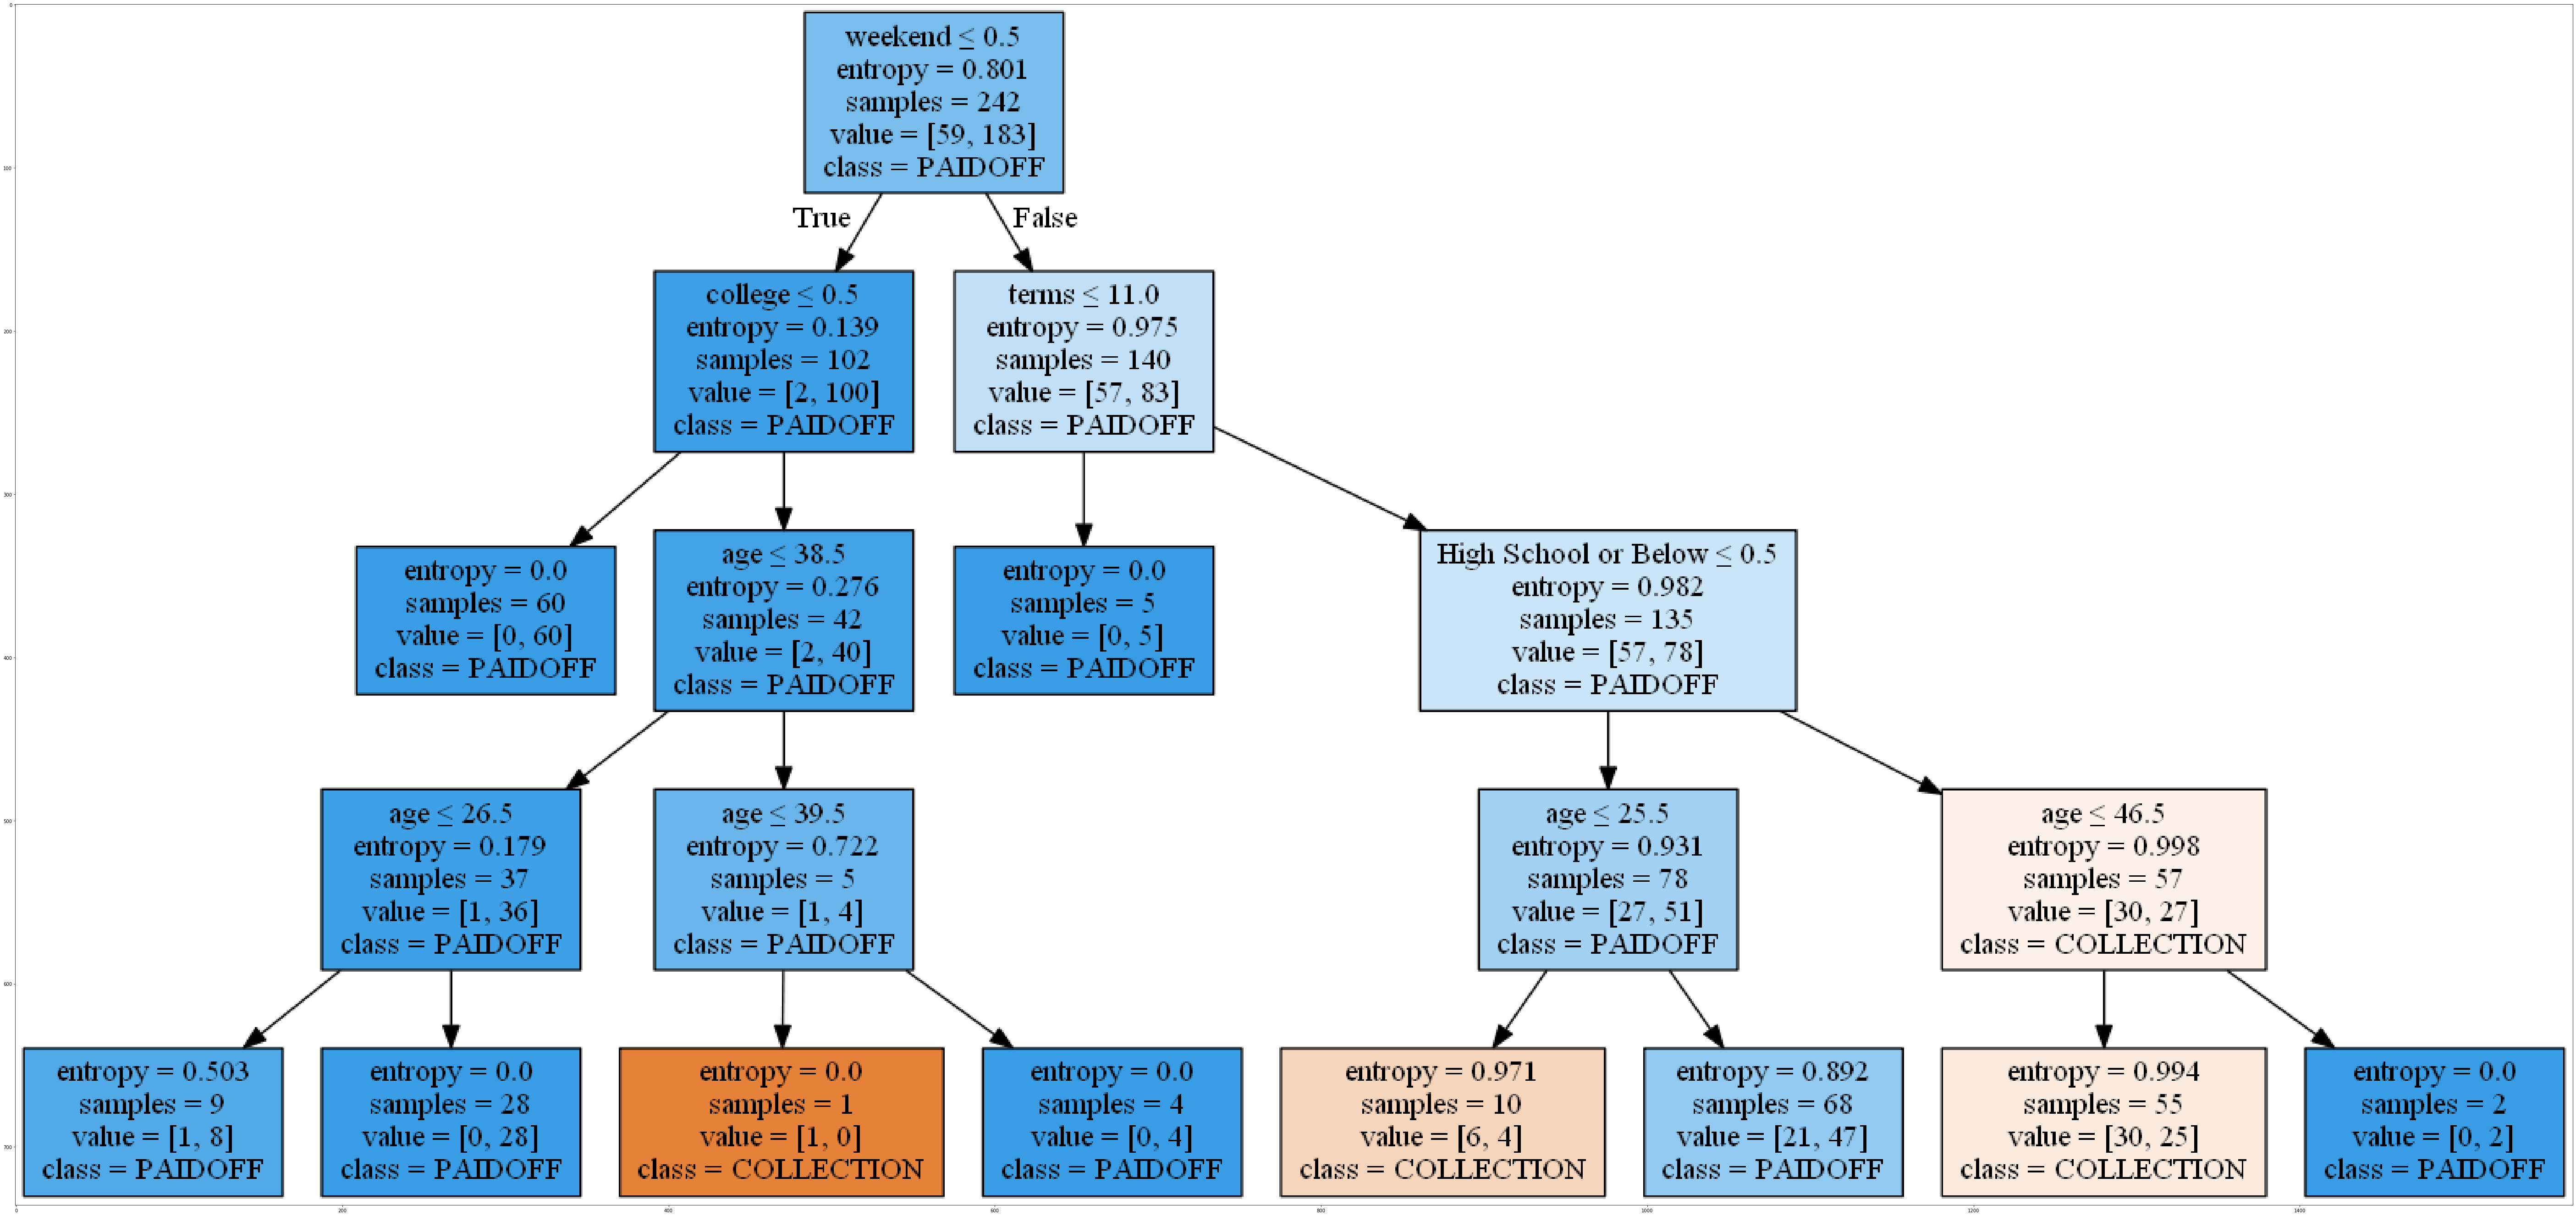

In [35]:
dot_data = StringIO()
filename = "Loantree.png"
featureNames = Feature.columns
out=tree.export_graphviz(LoanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y2_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [36]:
import scipy.optimize as opt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

In [37]:
#X3_df = df[['Principal','terms','age']]
X3_df = Feature
X3 = np.asarray(X3_df)
print (X3)

[[1000   30   45 ...    0    1    0]
 [1000   30   33 ...    1    0    0]
 [1000   15   27 ...    0    0    1]
 ...
 [ 800   15   39 ...    0    0    1]
 [1000   30   28 ...    0    0    1]
 [1000   30   26 ...    0    0    1]]


In [38]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
y3_df = df['loan_status']
print (y3_df)
y3_df = y3_df.astype('int')
y3= np.asarray(y3_df)
#y3[]

0      1
1      1
2      1
3      1
4      1
      ..
341    0
342    0
343    0
344    0
345    0
Name: loan_status, Length: 346, dtype: int64


In [39]:
X3_train, X3_test, y3_train, y3_test = train_test_split( X3, y3, test_size=0.2, random_state=4)
print ('Train set:', X3_train.shape,  y3_train.shape)
print ('Test set:', X3_test.shape,  y3_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [40]:
#Modelling
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X3_train, y3_train) 
#Predicted Values
yhat3 = clf.predict(X3_test)
yhat3 [0:5]

array([1, 1, 1, 1, 1])

In [41]:
#Confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.79      1.00      0.88        55

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[55  0]
 [15  0]]


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


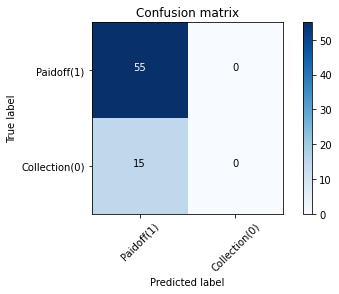

In [42]:
#Calculating Confusion Matrix
cnf_matrix = confusion_matrix(y3_test, yhat3, labels =[1,0])
np.set_printoptions(precision=2)

print (classification_report(y3_test, yhat3))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paidoff(1)','Collection(0)'],normalize= False,  title='Confusion matrix')

In [43]:
# jaccard_score

jaccard_score(y3_test, yhat3)
      


0.7857142857142857

In [44]:
# f1 score

f1_score(y3_test, yhat3, average='weighted')

0.6914285714285714

# Logistic Regression


In [45]:
!pip install scikit-learn==0.23.1

In [46]:
import scipy.optimize as opt

In [47]:
df_X4 = Feature
df_X4.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [48]:
df["loan_status"].head()

0    1
1    1
2    1
3    1
4    1
Name: loan_status, dtype: int64

In [49]:
X4 = np.asarray(df_X4)
y4 = np.asarray(df["loan_status"])
print (X4[0:5], y4[0:5])

[[1000   30   45    0    0    0    1    0]
 [1000   30   33    1    0    1    0    0]
 [1000   15   27    0    0    0    0    1]
 [1000   30   28    1    1    0    0    1]
 [1000   30   29    0    1    0    0    1]] [1 1 1 1 1]


In [50]:
X4 = preprocessing.StandardScaler().fit(X4).transform(X4)
X4 [0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

In [51]:
X4_train, X4_test, y4_train, y4_test = train_test_split( X4, y4, test_size=0.2, random_state=4)
print ('Train set:', X4_train.shape,  y4_train.shape)
print ('Test set:', X4_test.shape,  y4_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X4_train,y4_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [53]:
yhat4 = LR.predict(X4_test)
yhat4

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1], dtype=int64)

In [54]:
yhat4_prob = LR.predict_proba(X4_test)
yhat4_prob

array([[0.5 , 0.5 ],
       [0.45, 0.55],
       [0.31, 0.69],
       [0.34, 0.66],
       [0.32, 0.68],
       [0.32, 0.68],
       [0.49, 0.51],
       [0.48, 0.52],
       [0.34, 0.66],
       [0.49, 0.51],
       [0.34, 0.66],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.34, 0.66],
       [0.44, 0.56],
       [0.26, 0.74],
       [0.52, 0.48],
       [0.3 , 0.7 ],
       [0.5 , 0.5 ],
       [0.32, 0.68],
       [0.44, 0.56],
       [0.49, 0.51],
       [0.51, 0.49],
       [0.47, 0.53],
       [0.41, 0.59],
       [0.51, 0.49],
       [0.51, 0.49],
       [0.37, 0.63],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.47, 0.53],
       [0.46, 0.54],
       [0.46, 0.54],
       [0.48, 0.52],
       [0.39, 0.61],
       [0.46, 0.54],
       [0.5 , 0.5 ],
       [0.29, 0.71],
       [0.46, 0.54],
       [0.45, 0.55],
       [0.51, 0.49],
       [0.32, 0.68],
       [0.45, 0.55],
       [0.51, 0.49],
       [0.31, 0.69],
       [0.5 , 0.5 ],
       [0.47, 0.53],
       [0.5 ,

In [55]:
from sklearn.metrics import jaccard_score
jaccard_score(y4_test, yhat4)

0.6764705882352942

In [56]:
# Confusion Matrix function
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y4_test, yhat4, labels=[1,0]))

[[46  9]
 [13  2]]


Confusion matrix, without normalization
[[46  9]
 [13  2]]


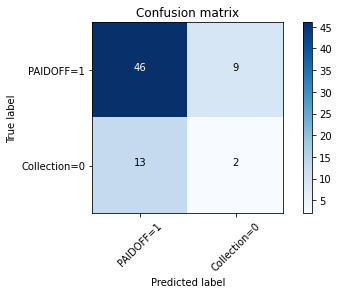

In [57]:
cnf_matrix = confusion_matrix(y4_test, yhat4, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF=1','Collection=0'],normalize= False,  title='Confusion matrix')

In [58]:
print (classification_report(y4_test, yhat4))

              precision    recall  f1-score   support

           0       0.18      0.13      0.15        15
           1       0.78      0.84      0.81        55

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70



In [59]:
from sklearn.metrics import log_loss
log_loss(y4_test, yhat4_prob)

0.5772287609479654

# Model Evaluation using Test set


In [60]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set: 
#Uncomment this following string with !wget in IBM Watson Studion 


In [61]:
#Uncomment this following string in IBM Watson Studion 
#!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation


In [62]:
test_df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv') 
print(test_df.head())
test_df1 = test_df.copy(deep=True)
print(test_df1.head())

   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30       9/8/2016   
1           5             5     PAIDOFF        300      7       9/9/2016   
2          21            21     PAIDOFF       1000     30      9/10/2016   
3          24            24     PAIDOFF       1000     30      9/10/2016   
4          35            35     PAIDOFF        800     15      9/11/2016   

    due_date  age             education  Gender  
0  10/7/2016   50              Bechalor  female  
1  9/15/2016   35       Master or Above    male  
2  10/9/2016   43  High School or Below  female  
3  10/9/2016   26               college    male  
4  9/25/2016   29              Bechalor    male  
   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30       9/8/2016   
1           5             5     PAIDOFF        300      7       9/9/2016   
2          21  

In [63]:
test_df.shape

(54, 10)

### Dataset preparation

In [64]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [65]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [66]:
#y_test_for_DT = test_df['loan_status'].values # this is for Decision Tree algorithm
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#y_test_dum = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [67]:
print (test_df[['Principal','terms','age','Gender','education']].head())
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

   Principal  terms  age  Gender             education
0       1000     30   50       1              Bechalor
1        300      7   35       0       Master or Above
2       1000     30   43       1  High School or Below
3       1000     30   26       0               college
4        800     15   29       0              Bechalor


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [68]:
X_test = Feature_test
print(X[0:5])
y_test= test_df['loan_status'].values
print(y[0:5])

[[ 0.52  0.92  2.33 -0.42 -1.21 -0.38  1.14 -0.87]
 [ 0.52  0.92  0.34  2.38 -1.21  2.62 -0.88 -0.87]
 [ 0.52 -0.96 -0.65 -0.42 -1.21 -0.38 -0.88  1.15]
 [ 0.52  0.92 -0.49  2.38  0.83 -0.38 -0.88  1.15]
 [ 0.52  0.92 -0.32 -0.42  0.83 -0.38 -0.88  1.15]]
[1 1 1 1 1]


In [69]:
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test[0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

## Model Tests

### K nearest neighbor (KNN)

In [70]:

k = 7 # from trainings above
#Train Model and Predict  
neigh_test_KNN = KNeighborsClassifier(n_neighbors = k).fit(X_test,y_test)
neigh_test_KNN

KNeighborsClassifier(n_neighbors=7)

In [71]:
yhat_KNN = neigh_test_KNN.predict(X_test)
yhat_KNN[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [72]:
KNN_met = metrics.accuracy_score(y_test, neigh_test_KNN.predict(X_test))
print("Metrics: ",KNN_met)



Metrics:  0.8703703703703703


In [73]:
test_df1['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
y_test_KNN = test_df1['loan_status'].values
print (y_test_KNN)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [74]:
k = 7 # from trainings above
#Train Model and Predict  
neigh_test_KNN1 = KNeighborsClassifier(n_neighbors = k).fit(X_test,y_test_KNN)
print (neigh_test_KNN1)


KNeighborsClassifier(n_neighbors=7)


In [75]:
yhat_KNN1 = neigh_test_KNN1.predict(X_test)
print(yhat_KNN1[0:5])


[1 1 1 1 1]


##### Scores of KNN

In [76]:
KNN_jaccard = jaccard_score(y_test_KNN , yhat_KNN1)
KNN_f1 =f1_score(y_test_KNN , yhat_KNN1, average='weighted')
print("Jaccard score: ", KNN_jaccard)
print("F1 score: ", KNN_f1)
print("Metrics: ",KNN_met)

Jaccard score:  0.8409090909090909
F1 score:  0.8687700045724738
Metrics:  0.8703703703703703


### Decision Tree

In [77]:
X_test_DT = X_test
y_test_DT = y_test
print(X_test_DT[0:5], y_test_DT[0:5])

[[ 0.49  0.93  3.06  1.98 -1.3   2.4  -0.8  -0.86]
 [-3.56 -1.7   0.53 -0.51  0.77 -0.42 -0.8  -0.86]
 [ 0.49  0.93  1.88  1.98  0.77 -0.42  1.25 -0.86]
 [ 0.49  0.93 -0.98 -0.51  0.77 -0.42 -0.8   1.16]
 [-0.67 -0.79 -0.48 -0.51  0.77  2.4  -0.8  -0.86]] ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [78]:
LoanTree_test = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
LoanTree_test.fit(X_test_DT,y_test)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [79]:
LoanpredTree_test = LoanTree_test.predict(X_test_DT)
print (LoanpredTree_test [0:5])

['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']


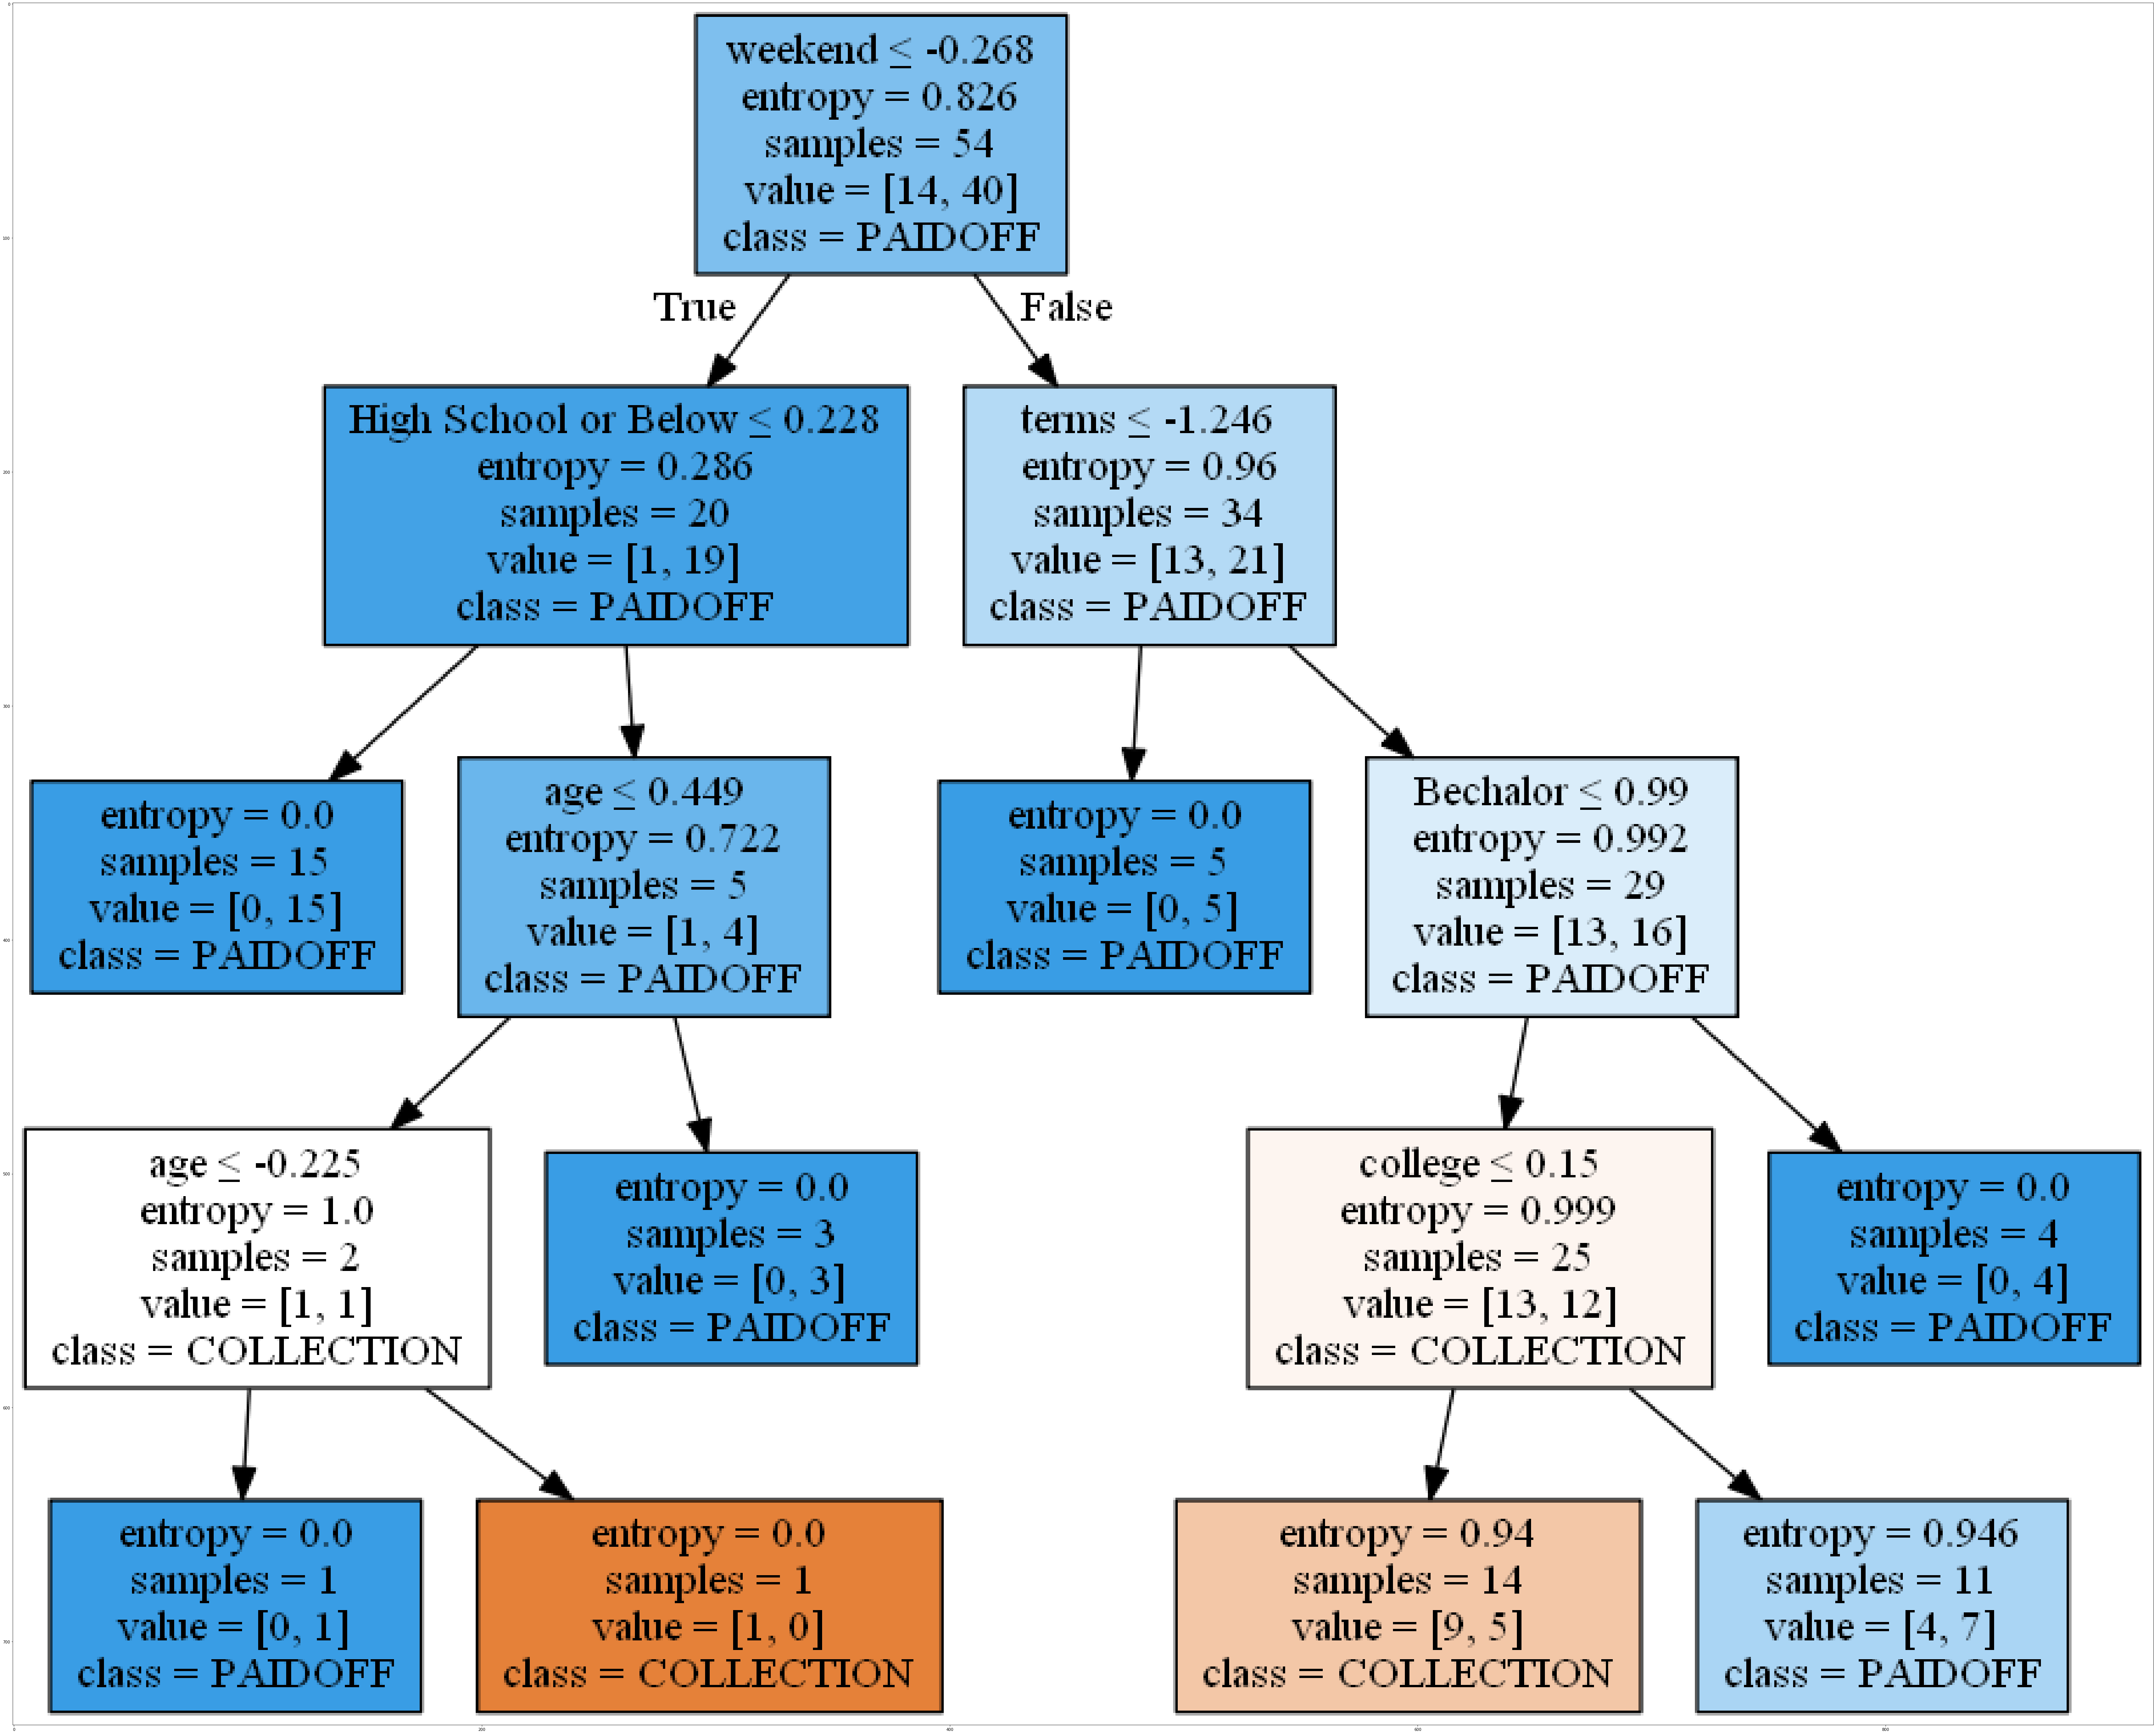

In [80]:
dot_data = StringIO()
filename = "Loantree_test.png"
featureNames_test = Feature_test.columns
out=tree.export_graphviz(LoanTree_test,feature_names=featureNames_test, out_file=dot_data, class_names= np.unique(y_test), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

In [81]:
DT_met = metrics.accuracy_score(y_test_DT, LoanpredTree_test)
print("Metrics: ",DT_met)


Metrics:  0.8333333333333334


In [82]:
y_test_DT1 = y_test_KNN

In [83]:
LoanTree_test1 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
LoanTree_test1.fit(X_test_DT,y_test_DT1)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [84]:
LoanpredTree_test1 = LoanTree_test1.predict(X_test_DT)
print (LoanpredTree_test1 [0:5])

[1 1 0 1 1]


#### Scores of Decision Tree

In [85]:
DT_jaccard = jaccard_score(y_test_DT1, LoanpredTree_test1)
DT_f1 =f1_score(y_test_DT1,LoanpredTree_test1, average='weighted')
print("Jaccard score: ", DT_jaccard)
print("F1 score: ", DT_f1)
print("Metrics: ",DT_met)

Jaccard score:  0.7954545454545454
F1 score:  0.835152044231049
Metrics:  0.8333333333333334


### Support Vector Machine

In [89]:
X_df_SVM = Feature_test
X_SVM = np.asarray(X_df_SVM)
print (X_SVM)

[[1000   30   50    1    0    1    0    0]
 [ 300    7   35    0    1    0    0    0]
 [1000   30   43    1    1    0    1    0]
 [1000   30   26    0    1    0    0    1]
 [ 800   15   29    0    1    1    0    0]
 [ 700   15   33    0    1    0    1    0]
 [1000   15   24    0    1    0    0    1]
 [1000   30   32    0    1    1    0    0]
 [ 800   15   27    1    1    0    0    1]
 [1000   15   37    0    1    0    0    1]
 [ 800   15   24    0    1    0    1    0]
 [ 300    7   35    0    1    0    0    1]
 [1000   30   31    0    1    1    0    0]
 [1000   30   37    1    1    0    0    1]
 [1000   30   37    1    1    0    1    0]
 [1000   30   33    0    1    0    0    1]
 [ 800   15   43    0    1    1    0    0]
 [1000    7   32    1    1    1    0    0]
 [1000   15   26    0    1    0    1    0]
 [1000    7   29    0    1    0    1    0]
 [1000   30   30    0    1    0    0    1]
 [1000    7   27    0    1    0    1    0]
 [ 300    7   37    0    0    0    0    0]
 [1000   15

In [87]:
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
y_SVM_df = test_df['loan_status']
print (y_SVM_df)
y_SVM_df = y_SVM_df.astype('int')
y_SVM = np.asarray(y_SVM_df)
y_SVM[0:5]

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
Name: loan_status, dtype: int64


array([1, 1, 1, 1, 1])

In [93]:
clf_SVM = svm.SVC(kernel='sigmoid')
clf_SVM.fit(X_SVM, y_SVM) 
#Predicted Values
yhat_SVM = clf.predict(X_SVM)
yhat_SVM [0:5]

array([1, 1, 1, 1, 1])

#### SVM Scores

In [94]:
# jaccard_score
SVM_jaccard = jaccard_score(y_SVM, yhat_SVM)

# f1 score
SVM_f1 = f1_score(y_SVM, yhat_SVM, average='weighted')

print('Jaccard Score: ', SVM_jaccard)
print('F1 score: ', SVM_f1)

Jaccard Score:  0.7407407407407407
F1 score:  0.6304176516942475


### Logistic Regression

In [92]:
LR_test_df = Feature_test
LR_test_df.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [96]:
LR_test_X = np.asarray(LR_test_df)
LR_test_y = np.asarray (test_df["loan_status"])
print(LR_test_X[0:5], LR_test_y[0:5])

[[1000   30   50    1    0    1    0    0]
 [ 300    7   35    0    1    0    0    0]
 [1000   30   43    1    1    0    1    0]
 [1000   30   26    0    1    0    0    1]
 [ 800   15   29    0    1    1    0    0]] [1 1 1 1 1]


In [97]:
LR_test_X  = preprocessing.StandardScaler().fit(LR_test_X ).transform(LR_test_X )
LR_test_X [0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

In [101]:
LR_test = LogisticRegression(C=0.01, solver='liblinear').fit(LR_test_X,LR_test_y)
LR_test

LogisticRegression(C=0.01, solver='liblinear')

In [102]:
LR_yhat = LR_test.predict(LR_test_X)
LR_yhat

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1], dtype=int64)

In [104]:
LR_yhat_prob = LR_test.predict_proba(LR_test_X)
LR_yhat_prob

array([[0.39, 0.61],
       [0.47, 0.53],
       [0.51, 0.49],
       [0.48, 0.52],
       [0.45, 0.55],
       [0.51, 0.49],
       [0.47, 0.53],
       [0.45, 0.55],
       [0.47, 0.53],
       [0.46, 0.54],
       [0.53, 0.47],
       [0.45, 0.55],
       [0.45, 0.55],
       [0.47, 0.53],
       [0.52, 0.48],
       [0.47, 0.53],
       [0.43, 0.57],
       [0.44, 0.56],
       [0.53, 0.47],
       [0.52, 0.48],
       [0.47, 0.53],
       [0.52, 0.48],
       [0.43, 0.57],
       [0.43, 0.57],
       [0.42, 0.58],
       [0.43, 0.57],
       [0.43, 0.57],
       [0.42, 0.58],
       [0.41, 0.59],
       [0.44, 0.56],
       [0.44, 0.56],
       [0.48, 0.52],
       [0.44, 0.56],
       [0.43, 0.57],
       [0.48, 0.52],
       [0.44, 0.56],
       [0.49, 0.51],
       [0.44, 0.56],
       [0.48, 0.52],
       [0.44, 0.56],
       [0.52, 0.48],
       [0.52, 0.48],
       [0.45, 0.55],
       [0.47, 0.53],
       [0.52, 0.48],
       [0.54, 0.46],
       [0.53, 0.47],
       [0.53,

#### Logostic Regression Scores

In [113]:
# jaccard_score
LR_jaccard = jaccard_score(LR_test_y, LR_yhat)

# f1 score
LR_f1 = f1_score(LR_test_y, LR_yhat, average='weighted')

#LogLoss
LR_logloss = log_loss(LR_test_y, LR_yhat_prob)



print('Jaccard Score: ', SVM_jaccard)
print('F1 score: ', SVM_f1)
print("LogLoss: ", LR_logloss)

Jaccard Score:  0.7407407407407407
F1 score:  0.6304176516942475
LogLoss:  0.6355095172018215


## Final Report

In [106]:
from astropy.table import QTable, Table, Column
from astropy import units as u

In [117]:
report = {"Algorithm":["KNN", "Decision Tree", "SVM", "Logistic Regression"],
          "Jaccard":[round(KNN_jaccard,3), round(DT_jaccard,3), round(SVM_jaccard,3), round(LR_jaccard,3)],
         "F1-score":[round(KNN_f1,3), round(DT_f1,3), round (SVM_f1,3), round(LR_f1,3)],
         "LogLoss":["NA","NA","NA",round(LR_logloss,3)]}

In [118]:
Table(report) 

Algorithm,Jaccard,F1-score,LogLoss
str19,float64,float64,str5
KNN,0.84,0.869,NA
Decision Tree,0.795,0.835,NA
SVM,0.741,0.63,NA
Logistic Regression,0.733,0.782,0.636


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
